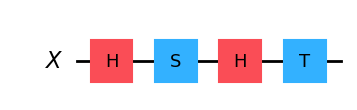

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Operator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

X = QuantumRegister(1, "X")
circuit = QuantumCircuit(X)
circuit.h(X)
circuit.s(X)
circuit.h(X)
circuit.t(X)

display(circuit.draw(output="mpl"))

In [ ]:
import numpy as np
import itertools

def generate_stabilizer_matrix(H, L, pattern):
    """
    Generates a binary stabilizer matrix from an X-type stabilizer pattern tiled over H x L grid.
    Only X stabilizers are supported for phase-flip LDPC codes.
    """
    n = H * L
    weight = np.sum(pattern)
    matrix = []

    # Apply stabilizer pattern to each valid center cell
    for i in range(H):
        for j in range(L):
            stab = np.zeros(n, dtype=int)
            for dx in range(-1, 2):
                for dy in range(-1, 2):
                    if pattern[dx + 1][dy + 1] == 1:
                        x, y = i + dx, j + dy
                        if 0 <= x < H and 0 <= y < L:
                            stab[x * L + y] = 1
            if np.any(stab):
                matrix.append(stab)
    return np.array(matrix)

def compute_rank(matrix):
    """Compute the rank of a binary matrix mod 2"""
    mat = matrix.copy()
    mat = mat % 2
    return np.linalg.matrix_rank(mat.astype(float))  # numpy does not support mod-2 rank, so float is okay for full-rank

def generate_logical_codewords(G):
    """Generate all codewords from generator matrix G"""
    k = G.shape[0]
    codewords = []
    for bits in itertools.product([0, 1], repeat=k):
        codeword = np.zeros(G.shape[1], dtype=int)
        for i, bit in enumerate(bits):
            if bit == 1:
                codeword ^= G[i]
        codewords.append(codeword)
    print(f"Generated {len(codewords)} codewords from generator matrix G.")
    codewords = np.array(codewords)
    # Ensure codewords are binary
    return np.array(codewords)

def compute_distance(codewords):
    """Return the minimal Hamming weight (excluding 0)"""
    weights = np.sum(codewords, axis=1)
    nonzero_weights = weights[weights > 0]
    return np.min(nonzero_weights) if len(nonzero_weights) > 0 else 0

# Example: Try a 3x3 grid and a simple cross pattern
H, L = 8, 17
n = H * L

# 3x3 X stabilizer pattern (center + N/S/E/W)
pattern = np.array([
    [0, 1, 0],
    [1, 1, 1]
])

S = generate_stabilizer_matrix(H, L, pattern)
print(S)
k = n - compute_rank(S)

# Generate generator matrix of code as nullspace of S
from scipy.linalg import null_space
G = null_space(S.astype(float), rcond=1e-5)
G = (np.round(G) % 2).astype(int)  # Convert to binary matrix

# Note: G might be empty if rank is full
if G.shape[0] == 0:
    print("No logical qubits.")
else:
    codewords = generate_logical_codewords(G)
    # d = compute_distance(codewords)
    # kd_over_n = (k * d) / n
    # print(f"n = {n}, k = {k}, d = {d}, kd/n = {kd_over_n:.2f}")


[[1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0]
 [0 1 0 0 1 1 1 0 1 1 1 0 0 0 0 0]
 [0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 0]
 [0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0]
 [0 0 0 0 0 1 0 0 1 1 1 0 1 1 1 0]
 [0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1]
 [0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1]
 [0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1]]
Generated 65536 codewords from generator matrix G.


In [41]:
def rule_fn(a, b, c):
    """Rule for updating Z matrix based on neighbors."""
    return 1 if (a + b + c) % 2 == 1 else 0

H, L = 8, 17
n = H * L
m = 2

Z = np.zeros((H, L), dtype=int)
Z[H-1, L//2] = 1

for i in range(H-m, -1, -1):
    for j in range(L):
        a = Z[i+1, j-1] if j-1 >= 0 else Z[i+1, L-1]
        b = Z[i+1, j]
        c = Z[i+1, j+1] if j+1 < L else Z[i+1, 0]
            
        Z[i, j] = rule_fn(a, b, c)

weight = np.sum(Z)
print(f"Total weight of Z matrix: {weight}")

print("Z matrix: ")
print(Z)


Total weight of Z matrix: 40
Z matrix: 
[[0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 0]
 [0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0]
 [0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0]
 [0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]


In [ ]:
H, L = 8, 17
n = H * L
m = 3

Z = np.zeros((H, L), dtype=int)
Z[H-1, L//2] = 1


for i in range(H-m, -1, -1):
    for j in range(L):
        a = Z[i+2, j-1] if j-1 >= 0 else Z[i+2, L-1]
        b = Z[i+1, j]
        c = Z[i+2, j+1] if j+1 < L else Z[i+2, 0]
            
        Z[i, j] = rule_fn(a, b, c)

weight = np.sum(Z)
print(f"Total weight of Z matrix: {weight}")

print("Z matrix:")
print(Z)


Total weight of Z matrix: 17
Z matrix:
[[0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]


In [70]:
H, L = 8, 17
n = H * L
m = 2

def rule_fn(a, b, c):
    """Rule for updating Z matrix based on neighbors."""
    return 1 if (a + b + c) % 2 == 1 else 0

def compute_min_distance(H, L, m, rule_fn):
    d_min = H * L  # upper bound

    for shift in range(L):
        Z = np.zeros((H, L), dtype=int)
        Z[H - 1, shift % L] = 1  # shift initial 1

        for i in range(H - m, -1, -1):
            for j in range(L):
                a = Z[i+1, j-1] if j-1 >= 0 else Z[i+1, L-1]
                b = Z[i+1, j]
                c = Z[i+1, j+1] if j+1 < L else Z[i+1, 0]
                    
                Z[i, j] = rule_fn(a, b, c)
                    
        weight = np.sum(Z)
        if weight != 0:
            d_min = min(d_min, weight)

    return d_min

d_min = compute_min_distance(H, L, m, rule_fn)
print(f"Minimum distance for m={m}: {d_min}")

Minimum distance for m=2: 40


In [7]:
H, L = 8, 17
n = H * L
m = 3

def rule_fn(a, b, c):
    """Rule for updating Z matrix based on neighbors."""
    return 1 if (a + b + c) % 2 == 1 else 0

def compute_min_distance(H, L, m, rule_fn):
    d_min = H * L  # upper bound

    for shift in range(L):
        Z = np.zeros((H, L), dtype=int)
        Z[H - 1, shift % L] = 1  # shift initial 1

        for i in range(H - m, -1, -1):
            for j in range(L):
                a = Z[i+2, j-1] if j-1 >= 0 else Z[i+2, L-1]
                b = Z[i+1, j]
                c = Z[i+2, j+1] if j+1 < L else Z[i+2, 0]
                    
                Z[i, j] = rule_fn(a, b, c)
                    
        weight = np.sum(Z)
        if weight != 0:
            d_min = min(d_min, weight)

    return d_min

d_min = compute_min_distance(H, L, m, rule_fn)
print(f"Minimum distance for m={m}: {d_min}")

Minimum distance for m=3: 17


In [5]:
import matplotlib.pyplot as plt

def rule_fn(a, b, c):
    """Rule for updating Z matrix based on neighbors."""
    return 1 if (a + b + c) % 2 == 1 else 0


# Generalized simulation and plotting for multiple m values
def generalized_kd_over_n_plot(H, L, m_values, rule_fn):
    results = []
    for m in m_values:
        k = (m - 1) * L
        n = H * L

        # Compute distance
        d = compute_min_distance(H, L, m, rule_fn)
        kd_over_n = (k * d) / n if d > 0 else 0

        results.append({
            'm': m,
            'k': k,
            'd': d,
            'n': n,
            'kd/n': kd_over_n
        })

    # Plot
    fig, ax = plt.subplots(figsize=(6, 5))
    for r in results:
        label = f"m={r['m']}"
        ax.scatter(r['d'], r['kd/n'], label=label, s=100)

    ax.set_xlabel("Code distance (d)")
    ax.set_ylabel("kd/n")
    ax.set_title(f"Performance of Cellular Automaton Codes (H={H}, L={L})")
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results

# Run for m=2, 3, 4 (3-row cellular automaton patterns)
m_values = [2, 3, 4]
results = generalized_kd_over_n_plot(H=8, L=17, m_values=m_values, rule_fn=rule_fn)


IndexError: index 8 is out of bounds for axis 0 with size 8

In [76]:
import numpy as np

def evolve_automaton(H, L, init_col, m, rule_fn):
    Z = np.zeros((H, L), dtype=int)
    Z[H - 1, init_col] = 1  # Single ∣i⟩ state at bottom

    for i in range(H - m, -1, -1):  # evolve upward
        for j in range(L):
            a = Z[i+2, j-1] if j-1 >= 0 else Z[i+2, L-1]
            b = Z[i+1, j]
            c = Z[i+2, j+1] if j+1 < L else Z[i+2, 0]
            Z[i, j] = rule_fn(a, b, c)

    return Z

def compute_kd_over_n(H, L, m, rule_fn):
    n = H * L
    k = (m - 1) * L

    d = H * L  # initialize large
    for shift in range(L):  # test all single-1 bottom row initializations
        Z = evolve_automaton(H, L, shift, m, rule_fn)
        weight = np.sum(Z)
        if weight != 0:
            d = min(d, weight)

    kd_over_n = (k * d) / n
    return k, d, n, kd_over_n

H, L = 8, 17
m = 3
def rule_fn(a, b, c):
    """Rule for updating Z matrix based on neighbors."""
    return 1 if (a + b + c) % 2 == 1 else 0

k, d, n, kd_over_n = compute_kd_over_n(H, L, m, rule_fn)
print(f"n = {n}, k = {k}, d = {d}, kd/n = {kd_over_n:.2f}")


n = 136, k = 34, d = 17, kd/n = 4.25


In [77]:
import numpy as np

def evolve_automaton(H, L, init_col, m, rule_fn):
    Z = np.zeros((H, L), dtype=int)
    Z[H - 1, init_col] = 1  # Single ∣i⟩ state at bottom

    for i in range(H - m, -1, -1):  # evolve upward
        for j in range(L):
            a = Z[i+1, j-1] if j-1 >= 0 else Z[i+1, L-1]
            b = Z[i+1, j]
            c = Z[i+1, j+1] if j+1 < L else Z[i+1, 0]
            Z[i, j] = rule_fn(a, b, c)

    return Z

def compute_kd_over_n(H, L, m, rule_fn):
    n = H * L
    k = (m - 1) * L

    d = H * L  # initialize large
    for shift in range(L):  # test all single-1 bottom row initializations
        Z = evolve_automaton(H, L, shift, m, rule_fn)
        weight = np.sum(Z)
        if weight != 0:
            d = min(d, weight)

    kd_over_n = (k * d) / n
    return k, d, n, kd_over_n

H, L = 8, 17
m = 2
def rule_fn(a, b, c):
    """Rule for updating Z matrix based on neighbors."""
    return 1 if (a + b + c) % 2 == 1 else 0

k, d, n, kd_over_n = compute_kd_over_n(H, L, m, rule_fn)
print(f"n = {n}, k = {k}, d = {d}, kd/n = {kd_over_n:.2f}")


n = 136, k = 17, d = 40, kd/n = 5.00


In [ ]:
import numpy as np

def evolve_automaton(H, L, init_col, m, rule_fn):
    Z = np.zeros((H, L), dtype=int)
    Z[H - 1, init_col] = 1  # Single ∣i⟩ state at bottom

    for i in range(H - m, -1, -1):  # evolve upward
        for j in range(L):
            a = Z[i+2, j-1] if j-1 >= 0 else Z[i+2, L-1]
            b = Z[i+2, j]
            c = Z[i+2, j+1] if j+1 < L else Z[i+2, 0]
            Z[i, j] = rule_fn(a, b, c)

    return Z

def compute_kd_over_n(H, L, m, rule_fn):
    n = H * L
    k = (m - 1) * L

    d = H * L  # initialize large
    for shift in range(L):  # test all single-1 bottom row initializations
        Z = evolve_automaton(H, L, shift, m, rule_fn)
        weight = np.sum(Z)
        if weight != 0:
            d = min(d, weight)

    kd_over_n = (k * d) / n
    return k, d, n, kd_over_n

H, L = 8, 17
m = 3
def rule_fn(a, b, c):
    """Rule for updating Z matrix based on neighbors."""
    return 1 if (a + b + c) % 2 == 1 else 0

k, d, n, kd_over_n = compute_kd_over_n(H, L, m, rule_fn)
print(f"n = {n}, k = {k}, d = {d}, kd/n = {kd_over_n:.2f}")


n = 136, k = 34, d = 12, kd/n = 3.00


Results:
m=2, k=17, d=27, n=136, kd/n=3.38
m=3, k=34, d=17, n=136, kd/n=4.25
m=4, k=51, d=9, n=136, kd/n=3.38


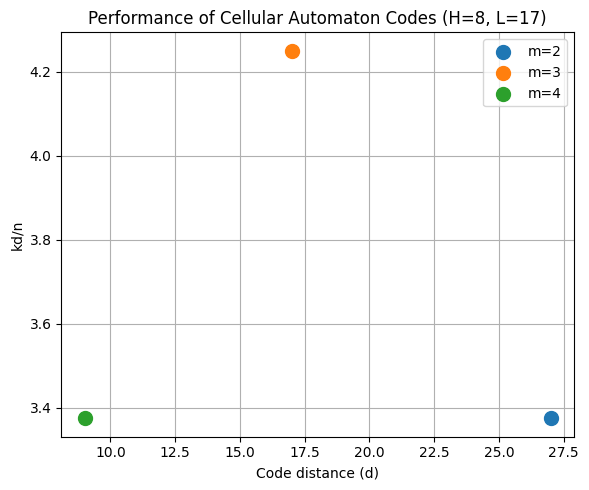

In [10]:
import matplotlib.pyplot as plt

def rule_fn(a, b, c):
    return 1 if (a + b + c) % 2 == 1 else 0

def compute_min_distance(H, L, m, rule_fn):
    d_min = H * L  # upper bound

    for shift in range(L):
        Z = np.zeros((H, L), dtype=int)
        Z[H - 1, shift % L] = 1  # shift initial 1

        for i in range(H - m, -1, -1):
            for j in range(L):
                a = Z[i + m - 1, j - 1] if j - 1 >= 0 else Z[i + m - 1, L - 1]
                b = Z[i + m - 2, j]
                c = Z[i + m - 1, j + 1] if j + 1 < L else Z[i + m - 1, 0]

                Z[i, j] = rule_fn(a, b, c)

        weight = np.sum(Z)
        if weight != 0:
            d_min = min(d_min, weight)

    return d_min

# Generalized simulation and plotting for multiple m values
def generalized_kd_over_n_plot(H, L, m_values, rule_fn):
    results = []
    for m in m_values:
        k = (m - 1) * L
        n = H * L

        # Compute distance
        d = compute_min_distance(H, L, m, rule_fn)
        kd_over_n = (k * d) / n if d > 0 else 0

        results.append({
            'm': m,
            'k': k,
            'd': d,
            'n': n,
            'kd/n': kd_over_n
        })

    print("Results:")
    for r in results:
        print(f"m={r['m']}, k={r['k']}, d={r['d']}, n={r['n']}, kd/n={r['kd/n']:.2f}")

    # Plot
    fig, ax = plt.subplots(figsize=(6, 5))
    for r in results:
        label = f"m={r['m']}"
        ax.scatter(r['d'], r['kd/n'], label=label, s=100)

    ax.set_xlabel("Code distance (d)")
    ax.set_ylabel("kd/n")
    ax.set_title(f"Performance of Cellular Automaton Codes (H={H}, L={L})")
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results


# Run for m=2, 3, 4 (3-row cellular automaton patterns)
m_values = [2, 3, 4]
results = generalized_kd_over_n_plot(H=8, L=17, m_values=m_values, rule_fn=rule_fn)